In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
from glob import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler,RobustScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from helper import *
from sklearn.utils import shuffle

%matplotlib inline



## Pipeline Plan
1. Feature extration
    * Sliding window
    * heat map
2. Classifier
3. Draw
    

# Load Data

In [2]:
def flip_img(img):
    # flip image to augment training data
    return img[:,::-1]

In [3]:
def autocast_uint8(img):
    if 'int' in str(img.dtype):
        return img.astype(np.uint8)
    img_ret = np.copy(img)
    if 'float' in str(img.dtype):
        return (img_ret*255).astype(np.uint8)

def autocast_float32(img):
    if 'float' in str(img.dtype):
        return img.astype(np.float32)
    img_ret = np.copy(img)
    if 'int' in str(img.dtype):
        return img_ret.astype(np.float32)/255.

    

    

In [4]:

def get_img_list_from_path_list(path_list):
    img_list = list()
    for path in path_list:
        im_now = mpimg.imread(path)
        img_list.append(autocast_uint8(flip_img(im_now)))
        img_list.append(autocast_uint8(im_now))
    return img_list

car_img_list = get_img_list_from_path_list(glob('training_img/vehicles/*/*.png'))
noCar_img_list = get_img_list_from_path_list(glob('training_img/non-vehicles/*/*.png'))

def plot2imgs(img_list,title_list):
    plt.figure(figsize=[15,5])
    for ii,(img,title) in enumerate(zip(img_list,title_list)):
        
        plt.subplot(1,2,ii+1)
        if 'heat' in title.lower():
            plt.imshow(img,cmap='hot')
        else:
            plt.imshow(img)
        plt.title(title)


In [5]:
# print stat
print("Training Data Breakdown")
print("\tNumber of Car imgs     : {}".format(len(car_img_list)))
print("\tNumber of Non-Car imgs : {}".format(len(noCar_img_list)))

Training Data Breakdown
	Number of Car imgs     : 17584
	Number of Non-Car imgs : 17936


In [6]:
test_img_path_list = glob('test_images/*')
test_img_list = list()
for img_path in test_img_path_list:
    test_img_list.append(autocast_uint8(mpimg.imread(img_path)))

### Make sure the imprted images are type np.float32 with scale of [0., 1.] for consistency

In [7]:
print("Type of Car Images : {}".format(car_img_list[0].dtype))
print("Type of No Car Images : {}".format(noCar_img_list[0].dtype))
print("Type of Test Images : {}".format(test_img_list[0].dtype))

Type of Car Images : uint8
Type of No Car Images : uint8
Type of Test Images : uint8


# Train the Classifier

In [31]:
def single_img_features(img, color_space='RGB', orient=9,pix_per_cell=8, cell_per_block=2):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      



    hog_features = []
    for channel in range(feature_image.shape[2]):
        hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                            orient, pix_per_cell, cell_per_block, 
                            vis=False, feature_vec=True))      

    return np.array(hog_features)

In [40]:
def train_classifier(color_space, orient, pix_per_cell,cell_per_block,
                     car_img_list,noCar_img_list):
    print('-------------------------------------------')
    print('Training Linear SVC with the paramers:')
    print('\tcolor_space = {}'.format(color_space))
    print('\torient = {}'.format(orient))
    print('\tpix_per_cell = {}'.format(pix_per_cell))
    print('\tcell_per_block = {}'.format(cell_per_block))
    
    # 1 - generate labels
    cars_labels = np.ones(len(car_img_list))
    noCar_lables = np.zeros(len(noCar_img_list))
    # 2 - combine the car images and non-car images
    img_all = np.vstack((np.stack(car_img_list),np.stack(noCar_img_list)))
    label_all = np.hstack((cars_labels,noCar_lables))
    # Sanity check print
#     print("img_all.shape = {}".format(img_all.shape))
#     print("label_all.shape = {}".format(label_all.shape))

    # 3 - Extract Features for all the imgs
    img_feature_all = np.array([single_img_features(img, color_space=color_space, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block).astype(np.float64) for img in img_all])



    X = img_feature_all                     
    X_scaler = RobustScaler().fit(X)
    scaled_X = X_scaler.transform(X) # Apply the scaler to X

    # Split up data into randomized training and test sets
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, label_all, test_size=0.2, random_state=np.random.randint(100))

#     print("Feature Dim : {}".format(X_train.shape[1]))

    svc = LinearSVC(loss='hinge') # Use a linear SVC 
    svc.fit(X_train, y_train) # Train the classifier

    print("Test Accuracy = {:1.4f}%".format(100*svc.score(X_test,y_test)))
    
    return 100*svc.score(X_test,y_test),X_scaler,svc

In [37]:
# Define parameters for feature extraction
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 32  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block

## Try different color space

In [38]:
feature_param_dict_list = [dict(color_space='YCrCb',orient=32,pix_per_cell=16,cell_per_block=2),
                           dict(color_space='RGB',orient=32,pix_per_cell=16,cell_per_block=2),
                           dict(color_space='HSV',orient=32,pix_per_cell=16,cell_per_block=2),
                           dict(color_space='LUV',orient=32,pix_per_cell=16,cell_per_block=2),
                           dict(color_space='HLS',orient=32,pix_per_cell=16,cell_per_block=2),
                           dict(color_space='YUV',orient=32,pix_per_cell=16,cell_per_block=2)]

In [42]:
for feature_param_dict in feature_param_dict_list:
    %%time tmp = train_classifier(car_img_list = car_img_list, noCar_img_list=noCar_img_list,**feature_param_dict)

-------------------------------------------
Training Linear SVC with the paramers:
	color_space = YCrCb
	orient = 32
	pix_per_cell = 16
	cell_per_block = 2
Test Accuracy = 98.3390%
CPU times: user 2min 38s, sys: 4.96 s, total: 2min 43s
Wall time: 2min 46s
-------------------------------------------
Training Linear SVC with the paramers:
	color_space = RGB
	orient = 32
	pix_per_cell = 16
	cell_per_block = 2
Test Accuracy = 95.9178%
CPU times: user 3min 15s, sys: 6.59 s, total: 3min 21s
Wall time: 3min 24s
-------------------------------------------
Training Linear SVC with the paramers:
	color_space = HSV
	orient = 32
	pix_per_cell = 16
	cell_per_block = 2
Test Accuracy = 96.8328%
CPU times: user 2min 49s, sys: 5.21 s, total: 2min 55s
Wall time: 2min 56s
-------------------------------------------
Training Linear SVC with the paramers:
	color_space = LUV
	orient = 32
	pix_per_cell = 16
	cell_per_block = 2
Test Accuracy = 98.2404%
CPU times: user 2min 47s, sys: 4.94 s, total: 2min 52s
Wa

## Try different orient
'YCrCb','LUV','YUV' all performed above 98%. I will use 'YCrCb', which had the highest accuracy.

In [43]:
feature_param_dict_list = [dict(color_space='YCrCb',orient=8,pix_per_cell=16,cell_per_block=2),
                           dict(color_space='YCrCb',orient=16,pix_per_cell=16,cell_per_block=2),
                           dict(color_space='YCrCb',orient=24,pix_per_cell=16,cell_per_block=2),
                           dict(color_space='YCrCb',orient=32,pix_per_cell=16,cell_per_block=2)]

In [44]:
for feature_param_dict in feature_param_dict_list:
    %%time tmp = train_classifier(car_img_list = car_img_list, noCar_img_list=noCar_img_list,**feature_param_dict)

-------------------------------------------
Training Linear SVC with the paramers:
	color_space = YCrCb
	orient = 8
	pix_per_cell = 16
	cell_per_block = 2
Test Accuracy = 98.2545%
CPU times: user 1min 41s, sys: 1.72 s, total: 1min 43s
Wall time: 1min 44s
-------------------------------------------
Training Linear SVC with the paramers:
	color_space = YCrCb
	orient = 16
	pix_per_cell = 16
	cell_per_block = 2
Test Accuracy = 98.3249%
CPU times: user 1min 57s, sys: 2.92 s, total: 2min
Wall time: 2min
-------------------------------------------
Training Linear SVC with the paramers:
	color_space = YCrCb
	orient = 24
	pix_per_cell = 16
	cell_per_block = 2
Test Accuracy = 98.3671%
CPU times: user 2min 15s, sys: 3.97 s, total: 2min 19s
Wall time: 2min 20s
-------------------------------------------
Training Linear SVC with the paramers:
	color_space = YCrCb
	orient = 32
	pix_per_cell = 16
	cell_per_block = 2
Test Accuracy = 98.3108%
CPU times: user 2min 46s, sys: 5.08 s, total: 2min 51s
Wall 

Choosing orient = 24 because it gives the best performance

## Final Parameters

In [45]:
color_space='YCrCb'
orient=24
pix_per_cell=16
cell_per_block=2

In [49]:
acc,X_scaler,svc = train_classifier(car_img_list = car_img_list, noCar_img_list=noCar_img_list,
                       color_space=color_space,orient=orient,pix_per_cell=pix_per_cell,cell_per_block=cell_per_block)

-------------------------------------------
Training Linear SVC with the paramers:
	color_space = YCrCb
	orient = 24
	pix_per_cell = 16
	cell_per_block = 2
Test Accuracy = 98.4657%


/Users/joonggonyim/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/sklearn/preprocessing/data.py:986: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/joonggonyim/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/sklearn/preprocessing/data.py:1037: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/joonggonyim/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/sklearn/preprocessing/data.py:986: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise Val

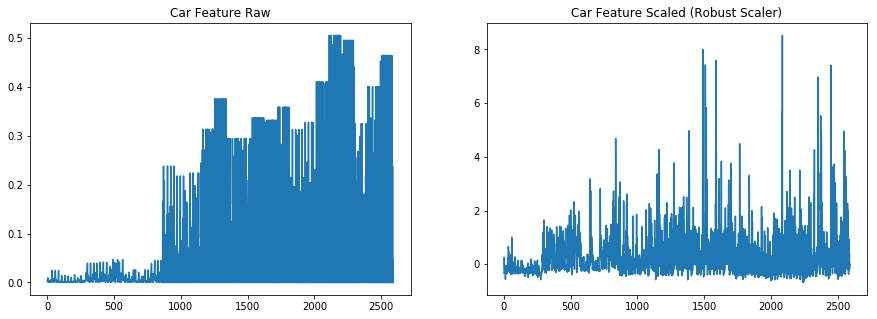

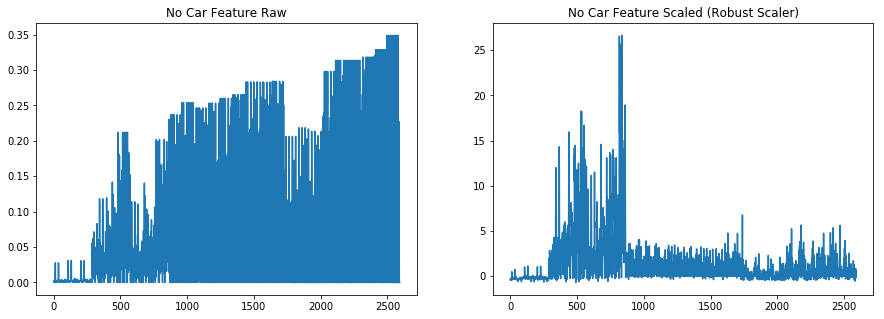

In [50]:
car_feature_sample = single_img_features(car_img_list[0], color_space=color_space,orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block)

nocar_feature_sample = single_img_features(noCar_img_list[0], color_space=color_space,orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block)
plt.figure(figsize=[15,5])
plt.subplot(1,2,1)
plt.plot(car_feature_sample)
plt.title('Car Feature Raw')

plt.subplot(1,2,2)
plt.plot(X_scaler.transform(car_feature_sample))
plt.title('Car Feature Scaled (Robust Scaler)')

# plt.subplot(1,3,3)
# plt.plot(X_scaler_standard.transform(car_feature_sample))
# plt.title('Car Feature Scaled (Standard Scaler)')

plt.figure(figsize=[15,5])
plt.subplot(1,2,1)
plt.plot(nocar_feature_sample)
plt.title('No Car Feature Raw')

plt.subplot(1,2,2)
plt.plot(X_scaler.transform(nocar_feature_sample))
plt.title('No Car Feature Scaled (Robust Scaler)')

# plt.subplot(1,3,3)
# plt.plot(X_scaler_standard.transform(nocar_feature_sample))
# plt.title('No Car Feature Scaled (Standard Scaler)')


# Test Classifier with Sliding Window

#### Define a list of Parameters

In [51]:
def draw_box(img,window_size,xy=None):

        
    ny,nx = img.shape[:2]
    if xy is None:
        x = 0
        y = ny
    else:
        x = xy[0]
        y = xy[1]
            
    bbox = (((x,y), (x+window_size,y-window_size)),)
    draw_img = draw_boxes(img, bbox)
    return draw_img

In [57]:
def find_cars(img, ystart, ystop, xstart, xstop, scale, svc, X_scaler,
                        color_space='RGB',orient=9, 
                        pix_per_cell=8, cell_per_block=2,cells_per_step=2, DEBUG=False):     
    
    draw_img = np.copy(img)
    img = autocast_uint8(img)
    
    img_tosearch = img[ystart:ystop,xstart:xstop,:]

    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img_tosearch)  
    
    ctrans_tosearch = feature_image
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    
    
    
    
    
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1   
    nfeat_per_block = orient*cell_per_block**2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    
    nblocks_per_window = (window // pix_per_cell)-1 
#     nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
#     cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    bbox = list()

    for xb in range(nxsteps):
        for yb in range(nysteps):
            img_features = []
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          

#             if hog_feat == True:
            img_features.append(hog_features)
            # Scale features and make a prediction

            
#             feature_tmp = np.hstack((spatial_features, hist_features[-1], hog_features)).reshape(1, -1)
            
            test_features = X_scaler.transform(np.concatenate(img_features).reshape(1, -1))    

            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1 or DEBUG:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox.append(((xstart + xbox_left, ytop_draw+ystart),(xstart+xbox_left+win_draw,ytop_draw+win_draw+ystart),scale))

                # cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return bbox

In [58]:
def multi_scale_find_cars(img, ystart_list, ystop_list,  xstart_list, xstop_list, scale_list, svc, X_scaler,
                        color_space='RGB',orient=9, pix_per_cell=8, cell_per_block=2,cells_per_step=2,DEBUG=False):

    hot_windows = list()
    for ystart,ystop,xstart,xstop,scale in zip(ystart_list, ystop_list,xstart_list, xstop_list, scale_list):
        hot_windows += find_cars(img, ystart, ystop, xstart, xstop, scale, svc, X_scaler,
                        color_space,orient, pix_per_cell, cell_per_block,cells_per_step, DEBUG=False)
    return hot_windows

In [59]:
from scipy.ndimage.measurements import label
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap_ret = np.copy(heatmap)
    heatmap_ret[heatmap_ret <= threshold] = 0
    # Return thresholded map
    return heatmap_ret

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    img = autocast_uint8(img)
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img



# Look for multiple windows

In [60]:
img = test_img_list[3]

## Window 1

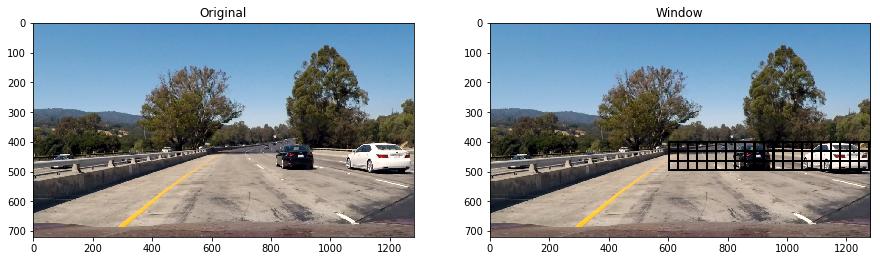

In [61]:
ystart = 400
ystop  = 500
scale = 1
xstart = 600
xstop = img.shape[1]
cells_per_step = 2
DEBUG=True
hot_windows = find_cars(img, ystart, ystop, xstart, xstop, scale, svc, X_scaler,
                        color_space,orient, pix_per_cell, cell_per_block,cells_per_step, DEBUG)
    
    
window_img = draw_boxes(np.copy(img),hot_windows,color=(0,0,1),thick=6)
plot2imgs((img,window_img),('Original','Window'))

## Window 2

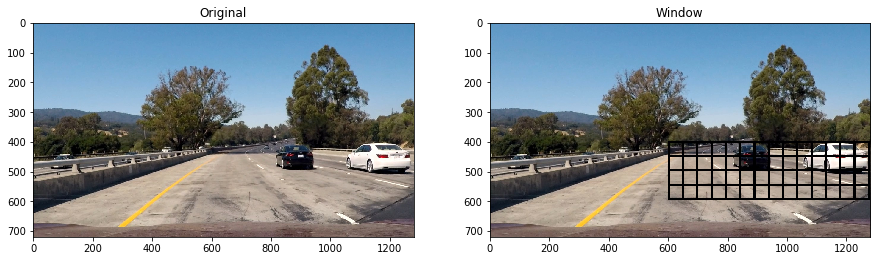

In [62]:
ystart = 400
ystop  = 600
scale = 1.5
xstart = 600
xstop = img.shape[1]
cells_per_step = 2
DEBUG=True
hot_windows = find_cars(img, ystart, ystop, xstart, xstop, scale, svc, X_scaler,
                        color_space,orient, pix_per_cell, cell_per_block,cells_per_step, DEBUG)
    
    
window_img = draw_boxes(np.copy(img),hot_windows,color=(0,0,1),thick=6)
plot2imgs((img,window_img),('Original','Window'))

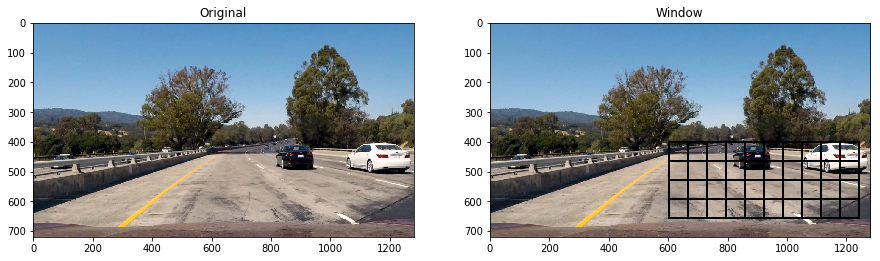

In [63]:
ystart = 400
ystop  = 700
scale = 2
xstart = 600
xstop = img.shape[1]
cells_per_step = 2
DEBUG=True
hot_windows = find_cars(img, ystart, ystop, xstart, xstop, scale, svc, X_scaler,
                        color_space,orient, pix_per_cell, cell_per_block,cells_per_step, DEBUG)
    
    
window_img = draw_boxes(np.copy(img),hot_windows,color=(0,0,1),thick=6)
plot2imgs((img,window_img),('Original','Window'))

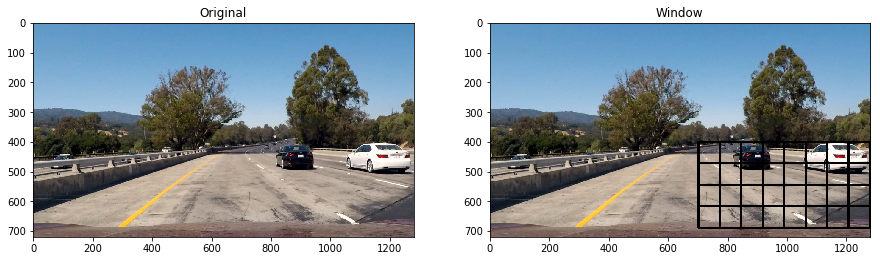

In [64]:
ystart = 400
ystop  = 700
scale = 2.25
xstart = 700
xstop = img.shape[1]
cells_per_step = 2
DEBUG=True
hot_windows = find_cars(img, ystart, ystop, xstart, xstop, scale, svc, X_scaler,
                        color_space,orient, pix_per_cell, cell_per_block,cells_per_step, DEBUG)
    
    
window_img = draw_boxes(np.copy(img),hot_windows,color=(0,0,1),thick=6)
plot2imgs((img,window_img),('Original','Window'))

In [65]:
scale_list = [1,1.5,2,2.25]
ystart_list = [400,400,400,400]
ystop_list = [500,600,700,700]
xstart_list = (700,)*len(scale_list)
xstop_list = (img.shape[1],)*len(scale_list)

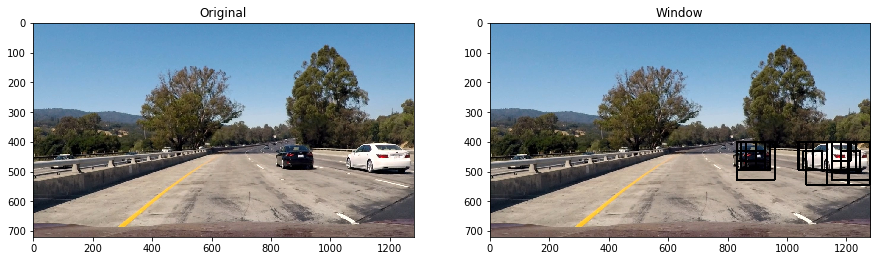

In [67]:
ystart = 400
ystop = 700

scale = 2
img = test_img_list[3]
xstart = 800
xstop = img.shape[1]
cells_per_step = 2
# img = autoscale_img(test_img_list[1],dtype=np.uint8)
DEBUG=True

MULTI = False
MULTI = True


# hot_windows = find_cars2(img, ystart, ystop, scale, color_space, hog_channel, svc, X_scaler, orient, 
#               pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=True)

if MULTI:
    hot_windows = multi_scale_find_cars(img, ystart_list, ystop_list, xstart_list, xstop_list, scale_list, svc, X_scaler,
                        color_space,orient, pix_per_cell, cell_per_block,cells_per_step, DEBUG=False)
else:
    hot_windows = find_cars(img, ystart, ystop, xstart, xstop, scale, svc, X_scaler,
                        color_space,orient, pix_per_cell, cell_per_block,cells_per_step, DEBUG=False)
    
    
window_img = draw_boxes(np.copy(img),hot_windows,color=(0,0,1),thick=6)
plot2imgs((img,window_img),('Original','Window'))

In [68]:
def pipeline(img, svc, X_scaler, ystart_list=None, ystop_list=None,  xstart_list=None, xstop_list=None, scale_list=[1,2,3],
            color_space='RGB',orient=9, pix_per_cell=8, cell_per_block=2,cells_per_step=2,
            discount=0,heat_th = 1,heatmap=None):
    
    
    
    if ystart_list is None:
        ystart_list = (400,)*len(scale_list)
    if ystop_list is None:
        ystop_list = (700,)*len(scale_list)
    if xstart_list is None:
        xstart_list = (0,)*len(scale_list)
    if xstop_list is None:
        xstop_list = (img.shape[1],)*len(scale_list)
    

    hot_windows = multi_scale_find_cars(img, ystart_list, ystop_list, xstart_list, xstop_list, scale_list, svc, X_scaler,
                        color_space,orient, pix_per_cell, cell_per_block,cells_per_step, DEBUG=False)
    if heatmap is None:
        heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    else:
        heatmap = discount*heatmap
    heatmap = add_heat(heatmap,hot_windows)

    heatmap_th = apply_threshold(heatmap,heat_th)
    heatmap_th = np.clip(heatmap_th, 0, 255)
    
    labels = label(heatmap_th)
    
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return heatmap,heatmap_th, draw_img

    

In [69]:
def combine_img_heatmap(draw_img,heatmap):
    heatmap_scale = np.copy(heatmap)

    heatmap_scale = autocast_uint8(heatmap_scale/np.amax(heatmap_scale))
    return np.hstack((draw_img,np.stack((heatmap_scale,)*3,axis=2)))

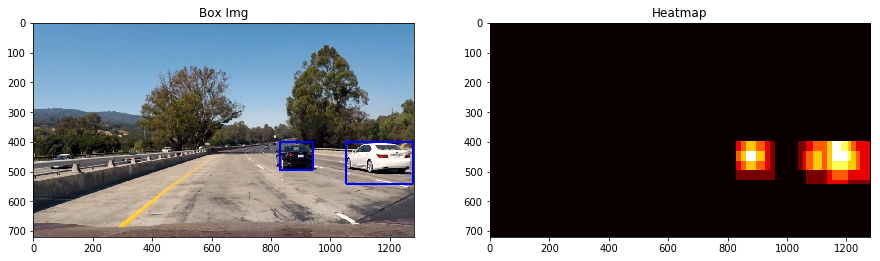

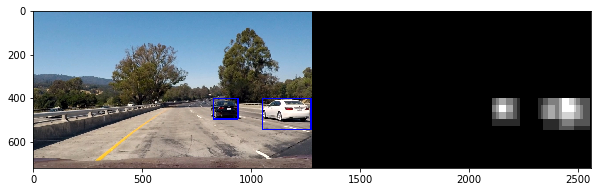

In [70]:
img = autocast_uint8(test_img_list[3])
heatmap,heatmap_th, draw_img = pipeline(img, svc, X_scaler, ystart_list, ystop_list,  xstart_list, xstop_list, scale_list,
            color_space,orient, pix_per_cell, cell_per_block,cells_per_step,
            discount=0,heat_th = 1)
plot2imgs((draw_img,heatmap),('Box Img','Heatmap'))
plt.figure(figsize=[10,5])
plt.imshow(combine_img_heatmap(draw_img,heatmap))

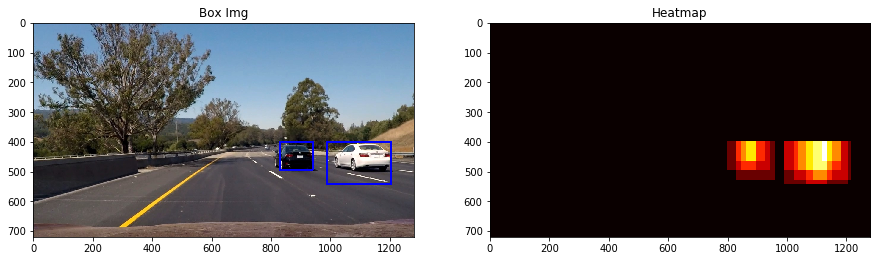

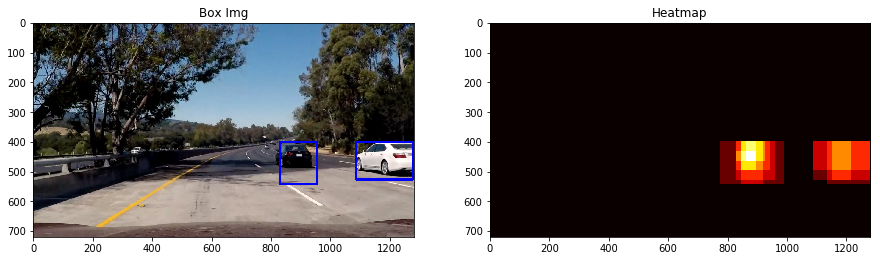

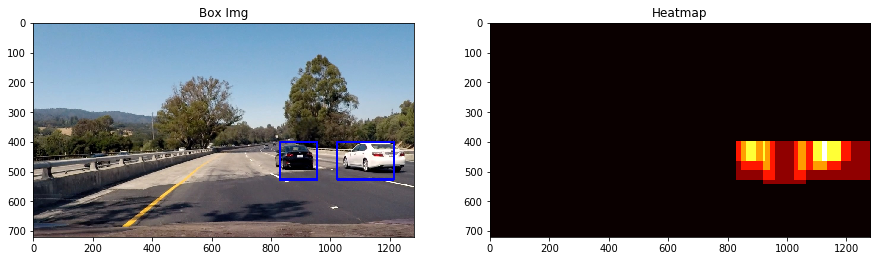

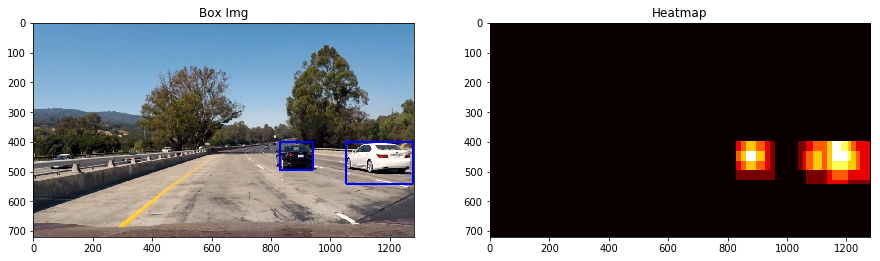

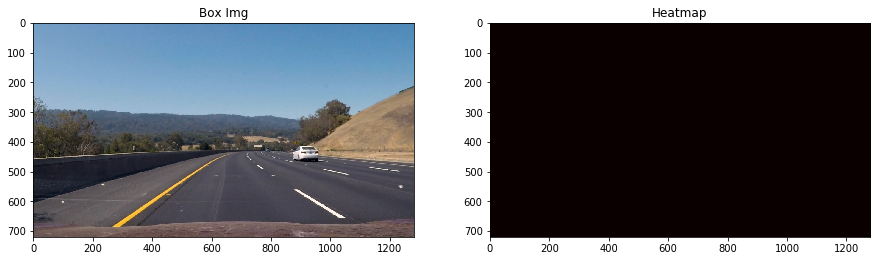

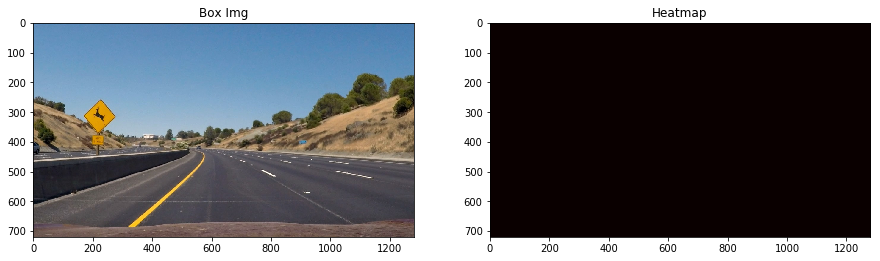

In [71]:
# -- Define

for img in test_img_list:
    heatmap,heatmap_th, draw_img = pipeline(img, svc, X_scaler, ystart_list, ystop_list,  xstart_list, xstop_list, scale_list,
            color_space,orient, pix_per_cell, cell_per_block,cells_per_step,
            discount=0,heat_th = 1)
    plot2imgs((draw_img,heatmap),('Box Img','Heatmap'))


In [72]:
from moviepy.editor import VideoFileClip

In [73]:
class VehicleDetector(object):
    
    def __init__(self,video_path,discount=0.5,heat_th=1):
        self._clip_in = VideoFileClip(video_path)
        self._out_path = video_path.replace('.mp4','_out.mp4')
        self._heatmap = None
        self._frame = 0
        self._discount = discount
        self._heat_th = heat_th

        self._scale_list = [1,1.5,2,2.25]
        self._ystart_list = [400,400,400,400]
        self._ystop_list = [500,600,700,700]
        self._xstart_list = (700,)*len(self._scale_list)
        self._xstop_list = (img.shape[1],)*len(self._scale_list)
        

        
        
        
    def _process_image(self,img):
        img = autocast_uint8(img)
        heatmap,heatmap_th, draw_img = pipeline(autocast_uint8(img), svc, X_scaler, 
                                                self._ystart_list, self._ystop_list,  
                                                self._xstart_list, self._xstop_list, 
                                                self._scale_list, color_space,orient, 
                                                pix_per_cell, cell_per_block,cells_per_step,
                                                discount=self._discount,heat_th =self._heat_th,
                                                heatmap=self._heatmap)
            
        self._heatmap = heatmap_th
        self._frame += 1
#         print(self._frame)
        return combine_img_heatmap(draw_img,heatmap)

    def process_frames(self,t,nframes):
        heatmap = None
        fps = self._clip_in.fps
        scale_list = [1.,1.5,2]
        for ii in range(nframes):
            t+= 1./fps
            img = self._clip_in.get_frame(t)
            heatmap, heatmap_th,draw_img  = pipeline(autocast_uint8(img), svc, X_scaler, 
                                                self._ystart_list, self._ystop_list,  
                                                self._xstart_list, self._xstop_list, 
                                                self._scale_list, color_space,orient, 
                                                pix_per_cell, cell_per_block,cells_per_step,
                                                discount=self._discount,heat_th =self._heat_th,
                                                heatmap=self._heatmap)
            
            plt.figure(figsize=[10,5])

            plt.imshow(combine_img_heatmap(draw_img,heatmap))
            
#             plot2imgs((draw_img,heatmap),('Box Img','Heatmap'))
            
    
    def process_video(self):
        
        self._clip_out = self._clip_in.fl_image(self._process_image)
        
        %time self._clip_out.write_videofile(self._out_path, audio=False)
        
    

In [74]:
# video_path = 'test_video.mp4'
video_path = 'project_video.mp4'
discount = 0.5
heat_th = 2.5

vd = VehicleDetector(video_path,discount=discount,heat_th=heat_th)

vd.process_video()

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [04:02<00:00,  4.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 3min 28s, sys: 36.8 s, total: 4min 5s
Wall time: 4min 3s
